**Import all the Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

**Set all the constants**

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

**Import data into tensorflow dataset object**

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../dataset/CNN",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10257 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['CANCER', 'COVID19', 'NORMAL', 'PNEUMONIA']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 1 0 2 0 1 2 0 1 3 0 3 0 2 0 3 3 2 3 0 0 2 0 2 2 0 2 1 2 1 2 1]


# Visualize some of the images from our dataset

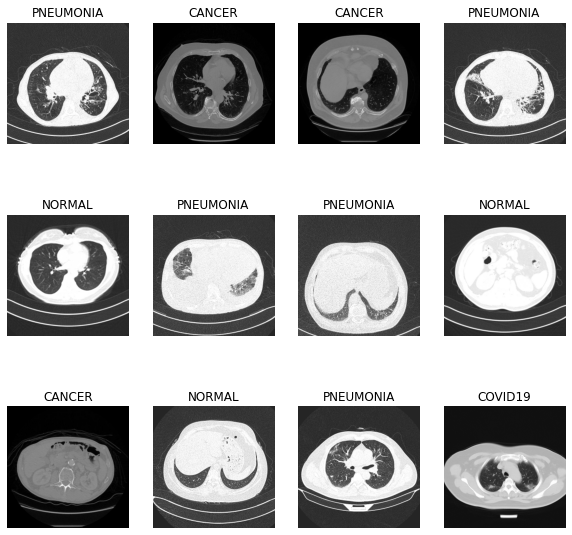

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

1- Training: Dataset to be used while training
2- Validation: Dataset to be tested against while training
3- Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

321

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

256

In [11]:
len(test_ds)

33

In [12]:
len(val_ds)

32

In [22]:
!pip install -U tensorflow

  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: libclang
    Found existing installation: libclang 12.0.0
    Uninstalling libclang-12.0.0:
      Successfully uninstalled libclang-12.0.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0


You should consider upgrading via the 'c:\users\abdel aziz\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


**Cache, Shuffle, and Prefetch the Dataset**

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# *Building the Model*

# 1- CNN

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

**Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data**

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

NotImplementedError: in user code:

    C:\Users\ABDELA~1\AppData\Local\Temp/ipykernel_15260/3649824265.py:2 None  *
        lambda x, y: (data_augmentation(x, training=True), y)
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:394 call
        outputs = layer(inputs, **kwargs)
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\keras\layers\preprocessing\image_preprocessing.py:827 call
        output = control_flow_util.smart_cond(training, random_rotated_inputs,
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\keras\utils\control_flow_util.py:109 smart_cond
        return smart_module.smart_cond(
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\framework\smart_cond.py:54 smart_cond
        return true_fn()
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\keras\layers\preprocessing\image_preprocessing.py:822 random_rotated_inputs
        get_rotation_matrix(angles, img_hd, img_wd),
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\keras\layers\preprocessing\image_preprocessing.py:729 get_rotation_matrix
        array_ops.zeros((num_angles, 2), dtypes.float32),
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:2911 wrapped
        tensor = fun(*args, **kwargs)
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:2960 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:2896 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3051 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:867 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_5/random_rotation_2/rotation_matrix/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


# Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.**

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model_CNN = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_CNN.build(input_shape=input_shape)

In [ ]:
model_CNN.summary()

# Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model_CNN.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model_CNN.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

In [ ]:
scores = model_CNN.evaluate(test_ds)

In [ ]:
scores

Scores is just a list containing loss and accuracy value

# Plotting the Accuracy and Loss Curves

In [ ]:
history.params

In [ ]:
history.history.keys()

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['val_accuracy'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc=np.array([history.history['accuracy']])
val_acc=np.array([history.history['val_accuracy']])
val_acc.shape

In [ ]:
plt.plot(range(EPOCHS), acc, 'g', label='Training loss')
plt.plot(range(EPOCHS), val_acc, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss_train=history.history['loss']
loss_val=history.history['val_loss']

plt.plot(range(EPOCHS), loss_train, 'g', label='Training loss')
plt.plot(range(EPOCHS), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model_CNN.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [ ]:
def predict(model_CNN, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_CNN.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_CNN, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model
**We append the model to the list of models as a new version**

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model_CNN.save(f"../saved_models/{model_version}")

In [ ]:
model_CNN.save("../model_CNN.h5")